![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Airline Buybacks
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Airline Buybacks hypothesis, then put the hypothesis in production.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/airline-buybacks">Documentation</a>

### Create Hypothesis
Buyback represents a company buy back its own stocks in the market, as (1) management is confident on its own future, and (2) wants more control over its development. Since usually buyback is in large scale on a schedule, the price of repurchasing often causes price fluctuation.

Airlines is one of the largest buyback sectors. Major US Airlines use over 90% of their free cashflow to buy back their own stocks in the recent years.<sup><a href="https://www.bloomberg.com/news/articles/2020-03-16/u-s-airlines-spent-96-of-free-cash-flow-on-buybacks-chart">[1]</a></sup> Therefore, we can use airline companies to test the hypothesis of buybacks would cause price action. In this particular exmaple, we're hypothesizing that difference in buyback price and close price would suggest price change in certain direction. (we don't know forward return would be in momentum or mean-reversion in this case!)

### Prerequisites
We'll need to use the <a href="https://www.quantconnect.com/datasets/smart-insider-corporate-buybacks/pricing/">Smart Insider Corporate Buybacks Transaction</a> dataset in this tutorial, you must subscribe to this dataset to get this data.

If you use Python, you must understand how to work with pandas DataFrames and Series. If you are not familiar with pandas, refer to the <a href="https://pandas.pydata.org/docs/">pandas documentation</a>.

### Import Libraries
We'll need to import libraries to help with data processing, validation and visualization. Import SmartInsiderTransaction, statsmodels, sklearn, numpy, pandas and seaborn libraries by the following:

In [1]:
from QuantConnect.DataSource import SmartInsiderTransaction

from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

### Get Historical Data
To begin, we retrieve historical data for research.

In [2]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the airline tickers for research.
assets = ["LUV",   # Southwest Airlines
          "DAL",   # Delta Airlines
          "UAL",   # United Airlines Holdings
          "AAL",   # American Airlines Group
          "SKYW",  # SkyWest Inc. 
          "ALGT",  # Allegiant Travel Co.
          "ALK"    # Alaska Air Group Inc.
         ]

# Call the AddEquity method with the tickers, and its corresponding resolution. Then call AddData with SmartInsiderTransaction to subscribe to their buyback transaction data. Save the Symbols into a dictionary.
symbols = {}
for ticker in assets:
    symbol = qb.AddEquity(ticker, Resolution.Minute).Symbol
    symbols[symbol] = qb.AddData(SmartInsiderTransaction, symbol).Symbol

# Call the History method with list of tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(list(symbols.keys()), datetime(2019, 1, 1), datetime(2021, 12, 31), Resolution.Daily)

# Call SPY history as reference.
spy = qb.History(qb.AddEquity("SPY").Symbol, datetime(2019, 1, 1), datetime(2021, 12, 31), Resolution.Daily)

# Call the History method with list of buyback tickers, time argument(s), and resolution to request buyback data for the symbol.
history_buybacks = qb.History(list(symbols.values()), datetime(2019, 1, 1), datetime(2021, 12, 31), Resolution.Daily)
history_buybacks

amount  \
symbol                                   time                             
LUV.SmartInsiderTransaction R735QTJ8XC9W 2019-02-06 11:46:36  1848814.0   
                                         2019-02-06 11:47:08  9835633.0   
                                         2019-05-01 09:48:51  6679187.0   
                                         2019-07-31 11:18:09  3654000.0   
                                         2019-07-31 11:19:22  5795570.0   
...                                                                 ...   
AAL.SmartInsiderTransaction VM9RIYHM8ACK 2020-02-20 06:28:04  4181541.0   
                                         2020-02-20 06:28:30  4975466.0   
                                         2020-05-01 11:18:29  1129820.0   
                                         2020-05-01 11:18:55  2912400.0   
                                         2020-05-01 11:19:34  2335805.0   

                                                             announcedin  \
symbol                                   time                              
LUV.SmartInsiderTransaction R735QTJ8XC9W 2019-02-06 11:46:36          US   
                                         2019-02-06 11:47:08          US   
                                         2019-05-01 09:48:51          US   
                                         2019-07-31 11:18:09          US   
                                         2019-07-31 11:19:22          US   
...                                                                  ...   
AAL.SmartInsiderTransaction VM9RIYHM8ACK 2020-02-20 06:28:04          US   
                                         2020-02-20 06:28:30          US   
                                         2020-05-01 11:18:29          US   
                                         2020-05-01 11:18:55          US   
                                         2020-05-01 11:19:34          US   

                                                             announcementdate  \
symbol                                   time                                   
LUV.SmartInsiderTransaction R735QTJ8XC9W 2019-02-06 11:46:36       2019-02-06   
                                         2019-02-06 11:47:08       2019-02-06   
                                         2019-05-01 09:48:51       2019-05-01   
                                         2019-07-31 11:18:09       2019-07-31   
                                         2019-07-31 11:19:22       2019-07-31   
...                                                                       ...   
AAL.SmartInsiderTransaction VM9RIYHM8ACK 2020-02-20 06:28:04       2020-02-20   
                                         2020-02-20 06:28:30       2020-02-20   
                                         2020-05-01 11:18:29       2020-05-01   
                                         2020-05-01 11:18:55       2020-05-01   
                                         2020-05-01 11:19:34       2020-05-01   

                                                             buybackdate  \
symbol                                   time                              
LUV.SmartInsiderTransaction R735QTJ8XC9W 2019-02-06 11:46:36  2018-10-31   
                                         2019-02-06 11:47:08  2018-12-31   
                                         2019-05-01 09:48:51  2019-03-31   
                                         2019-07-31 11:18:09  2019-04-30   
                                         2019-07-31 11:19:22  2019-06-30   
...                                                                  ...   
AAL.SmartInsiderTransaction VM9RIYHM8ACK 2020-02-20 06:28:04  2019-11-30   
                                         2020-02-20 06:28:30  2019-12-31   
                                         2020-05-01 11:18:29  2020-01-31   
                                         2020-05-01 11:18:55  2020-02-29   
                                         2020-05-01 11:19:34  2020-03-31   

                                                         

### Preparing Data
We'll have to process our data to get the buyback premium/discount% vs forward return data.

In [6]:
# Select the close column and then call the unstack method to get the close price dataframe.
df = history['close'].unstack(level=0)
spy_close = spy['close'].unstack(level=0)

# Call pct_change to get the daily return of close price, then shift 1-step backward as prediction.
ret = df.pct_change().shift(-1).iloc[:-1]
ret_spy = spy_close.pct_change().shift(-1).iloc[:-1]

# Get the active forward return.
active_ret = ret.sub(ret_spy.values, axis=0)

# Select the ExecutionPrice column and then call the unstack method to get the dataframe.
df_buybacks = history_buybacks['executionprice'].unstack(level=0)

# Convert buyback history into daily mean data.
df_buybacks = df_buybacks.groupby(df_buybacks.index.date).mean()
df_buybacks.columns = df.columns

# Get the buyback premium/discount %.
df_close = df.reindex(df_buybacks.index)[~df_buybacks.isna()]
df_buybacks = (df_buybacks - df_close)/df_close

# Create a dataframe to hold the buyback and 1-day forward return data.
data = pd.DataFrame(columns=["Buybacks", "Return"])

# Append the data into the dataframe.
for row, row_buyback in zip(active_ret.reindex(df_buybacks.index).itertuples(), df_buybacks.itertuples()):
    index = row[0]
    for i in range(1, df_buybacks.shape[1]+1):
        if row_buyback[i] != 0:
            data = pd.concat([data, pd.DataFrame({"Buybacks": row_buyback[i], "Return":row[i]}, index=[index])])

# Call dropna to drop NaNs.
data.dropna(inplace=True)
data.head(5)

,Buybacks,Return
2019-02-06,-1.000000,-0.003174
2019-02-16,0.004548,-0.028269
2019-02-16,0.105414,0.012359
2019-02-22,-0.045678,0.002298
2019-03-01,-0.077877,-0.012527


### Test the Hypothesis
We would test (1) if buyback has statistically significant effect on return direction, and (2) buyback could be a return predictor.

Optimization terminated successfully.
         Current function value: 0.634858
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            0
Date:                Mon, 10 Jan 2022   Pseudo R-squ.:                 0.08311
Time:                        15:06:00   Log-Likelihood:                -33.013
converged:                       True   LL-Null:                       -36.005
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.5215      0.742     -2.051      0.040      -2.976      -0.067
==============================================================================
"""

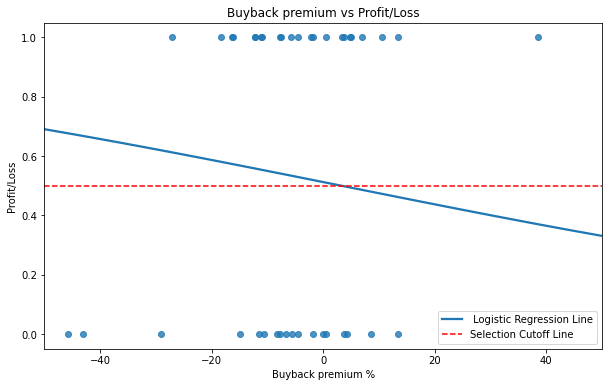

In [4]:
# Get binary return (+/-).
binary_ret = data["Return"].copy()
binary_ret[binary_ret < 0] = 0
binary_ret[binary_ret > 0] = 1

# Construct a logistic regression model.
model = Logit(binary_ret.values, data["Buybacks"].values).fit()

# Display logistic regression results.
display(model.summary())

# Plot the result.
plt.figure(figsize=(10, 6))
sns.regplot(x=data["Buybacks"]*100, y=binary_ret, logistic=True, ci=None, line_kws={'label': " Logistic Regression Line"})
plt.plot([-50, 50], [0.5, 0.5], "r--", label="Selection Cutoff Line")
plt.title("Buyback premium vs Profit/Loss")
plt.xlabel("Buyback premium %")
plt.xlim([-50, 50])
plt.ylabel("Profit/Loss")
plt.legend()
plt.show()

We can see a p-value of < 0.05 in the logistic regression model, meaning the separation of positive and negative is statistically significant. Interesting, from the logistic regression line, we observe that when the airlines brought their stock in premium price, the price tended to go down, while the opposite for buying back in discount.

In [5]:
# Get in-sample prediction result.
predictions = model.predict(data["Buybacks"].values)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i] > 0.5 else 0

# Call confusion_matrix to contrast the results.
cm = confusion_matrix(binary_ret, predictions)

# Display the result.
df_result = pd.DataFrame(cm, 
                        index=pd.MultiIndex.from_tuples([("Prediction", "Positive"), ("Prediction", "Negative")]),
                        columns=pd.MultiIndex.from_tuples([("Actual", "Positive"), ("Actual", "Negative")]))
df_result 

Actual         
                    Positive Negative
Prediction Positive       11       14
           Negative        9       18

The logistic regression is having a 55.8% accuracy (55% sensitivity and 56.3% specificity), this can suggest a > 50% win rate before friction, proven our hypothesis.

### Source

[1] US Airlines Spent 96% of Free Cash Flow on Buybacks: Chart. B. Kochkodin (17 March 2020). Bloomberg. Retrieve from: https://www.bloomberg.com/news/articles/2020-03-16/u-s-airlines-spent-96-of-free-cash-flow-on-buybacks-chart.